In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [2]:
!pip install torchsummary

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.leaky1 = nn.LeakyReLU()
        self.dropout = nn.Dropout()
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.leaky2 = nn.LeakyReLU()
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.leaky3 = nn.LeakyReLU()
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.leaky4 = nn.LeakyReLU()
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.batchnorm4 = nn.BatchNorm2d(128)
        self.leaky5 = nn.LeakyReLU()
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.leaky6 = nn.LeakyReLU()
        self.avgpool = nn.AvgPool2d(2, stride=2)
        self.fc = nn.Linear(4 * 4 * 128, 11)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.leaky1(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.batchnorm1(x)
        x = self.leaky2(x)
        x = self.conv3(x)
        x = self.batchnorm2(x)
        x = self.leaky3(x)
        x = self.conv4(x)
        x = self.batchnorm3(x)
        x = self.leaky4(x)
        x = self.conv5(x)
        x = self.batchnorm4(x)
        x = self.leaky5(x)
        x = self.conv6(x)
        x = self.leaky6(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc(x)
        x = self.softmax(x)
        return x

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.conv1 = nn.ConvTranspose2d(100, 256, kernel_size=4, stride=4, padding=0, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(256)
        self.leaky1 = nn.LeakyReLU()
        self.conv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=4, padding=0, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.leaky2 = nn.LeakyReLU()
        self.conv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.leaky3 = nn.LeakyReLU()
        self.conv4 = nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.leaky1(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.leaky2(x)
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.leaky3(x)
        x = self.conv4(x)
        x = self.tanh(x)
        return x

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Define transforms for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Resize((64, 64), antialias=False)
])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15962968.56it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 468938.38it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3763369.47it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2491567.98it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
def plot_samples(samples):
    fig = plt.figure(figsize=(20, 5))
    for j in range(len(samples)):  
        ax = fig.add_subplot(1, len(samples), j+1)
        sample = samples[j][0].squeeze().cpu().detach().numpy()  
        ax.imshow(sample, cmap='gray')
        ax.axis('off')
    plt.show()
    
def test_accuracy(discriminator, testloader, device):
    correct = 0
    total = 0
    discriminator.eval()
    with torch.no_grad():
        for data in tqdm(testloader):
            inputs, labels = data[0].to(device), data[1].to(device)  # Chuyển dữ liệu lên GPU
            outputs = discriminator(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate test accuracy
    test_accuracy = 100 * correct / total
    return test_accuracy


In [6]:
def plot_losses(dLosses, gLosses):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show

In [9]:
def save_model(path, model, epoch):
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
    },path)

In [10]:
def load_model(path):
    check_point = torch.load(path)
    return check_point

In [11]:
def ns_generator_loss(fake_output):
    return -torch.mean(torch.log(fake_output))

In [12]:
def s_generator_loss(generated_output):
    return torch.mean(1-torch.log(generated_output))

In [13]:
criterion_ = nn.NLLLoss()
def discriminator_loss(pred_labels, real_labels):   
    log_probs = torch.log(pred_labels)
    loss = criterion_(log_probs, real_labels)
    return loss

In [15]:
# Tạo các đối tượng Discriminator và Generator
lr = 0.0002
D = Discriminator().to(device)
G = Generator().to(device)
#criterion = nn.CrossEntropyLoss()
# Định nghĩa optimizer cho Discriminator và Generator
d_optimizer = optim.Adam(D.parameters(), lr=lr)
g_optimizer = optim.Adam(G.parameters(), lr=lr)
accuracy_list = []
loss_list = []
sample_of_generator = []
num_epochs = 100
# Huấn luyện mô hình
d_losses = []
g_losses = []
for epoch in range(num_epochs):
    D.train()
    G.train()
    epoch_d_loss = 0
    epoch_g_loss = 0
    with tqdm(trainloader, unit="batch") as tepoch:
        for i, data in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch}")
            inputs, labels = data[0].to(device), data[1].to(device)  # Chuyển dữ liệu lên GPU
            # Chuẩn bị dữ liệu
            real_data = data[0].to(device)
            fake_label = torch.full((data[0].size(0),), 10).to(device)
            # Huấn luyện Discriminator với dữ liệu thật
            d_optimizer.zero_grad()
            d_output_real = D(real_data)
            d_loss_real = discriminator_loss(d_output_real, labels)

            # Huấn luyện Discriminator với dữ liệu giả
            noise = torch.randn(data[0].size(0), 100, 1, 1).to(device)
            fake_data = G(noise)
            d_output_fake = D(fake_data.detach())
            d_loss_fake = discriminator_loss(d_output_fake, fake_label)
            
            # Tổng hợp loss và cập nhật Discriminator
            d_loss = (d_loss_real + d_loss_fake)
            #d_loss = discriminator_loss(d_output_real, d_output_fake)/2
            d_loss.backward()
            d_optimizer.step()

            # Huấn luyện Generator
            g_optimizer.zero_grad()
            noise = torch.randn(data[0].size(0), 100, 1, 1).to(device)
            fake_data = G(noise)
            #d_output = D(fake_data)
            feature_fake = D(fake_data)
            g_loss = ns_generator_loss(feature_fake)
            
            g_loss.backward()
            g_optimizer.step()

            epoch_d_loss+=d_loss.item()
            epoch_g_loss+=g_loss.item()
            g_losses.append(g_loss.item())
            d_losses.append(d_loss.item())
            
        epoch_d_loss/=i
        epoch_g_loss/=i
        print(f"Epoch {epoch}: Generator Loss: {epoch_g_loss}; Discriminator Loss: {epoch_d_loss}")
        
    with open("gan_mnist.txt",'a') as f:
        f.writelines(f"\tEpoch {epoch}: Generator Loss: {epoch_g_loss}; Discriminator Loss: {epoch_d_loss} \n")



Epoch 0: 100%|██████████| 235/235 [00:44<00:00,  5.23batch/s]


Epoch 0: Generator Loss: 9.269780066278246; Discriminator Loss: 0.7618301720318631


Epoch 1: 100%|██████████| 235/235 [00:43<00:00,  5.37batch/s]


Epoch 1: Generator Loss: 11.639779975271633; Discriminator Loss: 0.16132074057992196


Epoch 2: 100%|██████████| 235/235 [00:43<00:00,  5.38batch/s]


Epoch 2: Generator Loss: 11.138682870783358; Discriminator Loss: 0.14157309153905281


Epoch 3: 100%|██████████| 235/235 [00:43<00:00,  5.40batch/s]


Epoch 3: Generator Loss: 11.991875677027254; Discriminator Loss: 0.14201565160073787


Epoch 4: 100%|██████████| 235/235 [00:43<00:00,  5.38batch/s]


Epoch 4: Generator Loss: 12.009519299890242; Discriminator Loss: 0.14540618436777183


Epoch 5: 100%|██████████| 235/235 [00:43<00:00,  5.36batch/s]


Epoch 5: Generator Loss: 12.67711276274461; Discriminator Loss: 0.12806050213547343


Epoch 6: 100%|██████████| 235/235 [00:43<00:00,  5.38batch/s]


Epoch 6: Generator Loss: 13.238845870026157; Discriminator Loss: 0.17961219258797476


Epoch 7: 100%|██████████| 235/235 [00:43<00:00,  5.40batch/s]


Epoch 7: Generator Loss: 13.109916083833092; Discriminator Loss: 0.16476515292102456


Epoch 8: 100%|██████████| 235/235 [00:43<00:00,  5.41batch/s]


Epoch 8: Generator Loss: 13.234339697748167; Discriminator Loss: 0.2076403265580153


Epoch 9: 100%|██████████| 235/235 [00:43<00:00,  5.41batch/s]


Epoch 9: Generator Loss: 13.248933148180317; Discriminator Loss: 0.19349725429828352


Epoch 10: 100%|██████████| 235/235 [00:43<00:00,  5.40batch/s]


Epoch 10: Generator Loss: 13.557577813792433; Discriminator Loss: 0.25429745317779034


Epoch 11: 100%|██████████| 235/235 [00:43<00:00,  5.40batch/s]


Epoch 11: Generator Loss: 13.710306216508915; Discriminator Loss: 0.2102602534314506


Epoch 12: 100%|██████████| 235/235 [00:43<00:00,  5.36batch/s]


Epoch 12: Generator Loss: 13.892256011310806; Discriminator Loss: 0.3100569438284788


Epoch 13: 100%|██████████| 235/235 [00:43<00:00,  5.37batch/s]


Epoch 13: Generator Loss: 13.806515604002863; Discriminator Loss: 0.24480677195466483


Epoch 14: 100%|██████████| 235/235 [00:43<00:00,  5.41batch/s]


Epoch 14: Generator Loss: 13.905893578488602; Discriminator Loss: 0.3013163392041993


Epoch 15: 100%|██████████| 235/235 [00:43<00:00,  5.37batch/s]


Epoch 15: Generator Loss: 13.933172022175585; Discriminator Loss: 0.20109379215118212


Epoch 16: 100%|██████████| 235/235 [00:43<00:00,  5.41batch/s]


Epoch 16: Generator Loss: 13.96216611780672; Discriminator Loss: 0.32567813190130085


Epoch 17: 100%|██████████| 235/235 [00:43<00:00,  5.42batch/s]


Epoch 17: Generator Loss: 14.003059293469812; Discriminator Loss: 0.19693739801390558


Epoch 18: 100%|██████████| 235/235 [00:43<00:00,  5.41batch/s]


Epoch 18: Generator Loss: 14.03586093788473; Discriminator Loss: 0.2145002219093661


Epoch 19: 100%|██████████| 235/235 [00:43<00:00,  5.40batch/s]


Epoch 19: Generator Loss: 14.316899474869427; Discriminator Loss: 0.28257923423607123


Epoch 20: 100%|██████████| 235/235 [00:43<00:00,  5.41batch/s]


Epoch 20: Generator Loss: 14.369427778781988; Discriminator Loss: 0.19501320637253106


Epoch 21: 100%|██████████| 235/235 [00:43<00:00,  5.40batch/s]


Epoch 21: Generator Loss: 14.401221450577435; Discriminator Loss: 0.22887896556948495


Epoch 22: 100%|██████████| 235/235 [00:43<00:00,  5.44batch/s]


Epoch 22: Generator Loss: 14.589185030032427; Discriminator Loss: 0.17903227661537308


Epoch 23: 100%|██████████| 235/235 [00:43<00:00,  5.43batch/s]


Epoch 23: Generator Loss: 14.759624819470266; Discriminator Loss: 0.2440606130159691


Epoch 24: 100%|██████████| 235/235 [00:43<00:00,  5.43batch/s]


Epoch 24: Generator Loss: 14.81967576344808; Discriminator Loss: 0.18670787472819161


Epoch 25: 100%|██████████| 235/235 [00:43<00:00,  5.42batch/s]


Epoch 25: Generator Loss: 14.66144715415107; Discriminator Loss: 0.23888329507257694


Epoch 26: 100%|██████████| 235/235 [00:43<00:00,  5.41batch/s]


Epoch 26: Generator Loss: 14.793123628339197; Discriminator Loss: 0.21812568246745145


Epoch 27: 100%|██████████| 235/235 [00:43<00:00,  5.38batch/s]


Epoch 27: Generator Loss: 14.969512108044746; Discriminator Loss: 0.18800151229509685


Epoch 28: 100%|██████████| 235/235 [00:43<00:00,  5.40batch/s]


Epoch 28: Generator Loss: 15.065008656591433; Discriminator Loss: 0.25855609317684275


Epoch 29: 100%|██████████| 235/235 [00:43<00:00,  5.37batch/s]


Epoch 29: Generator Loss: 15.193138318184095; Discriminator Loss: 0.06888901655617942


Epoch 30: 100%|██████████| 235/235 [00:43<00:00,  5.35batch/s]


Epoch 30: Generator Loss: 15.370892769251114; Discriminator Loss: 0.11031639426309839


Epoch 31: 100%|██████████| 235/235 [00:44<00:00,  5.33batch/s]


Epoch 31: Generator Loss: 15.863812540331457; Discriminator Loss: 0.21635847547465664


Epoch 32: 100%|██████████| 235/235 [00:43<00:00,  5.34batch/s]


Epoch 32: Generator Loss: 15.22667337890364; Discriminator Loss: 0.20196815956638664


Epoch 33: 100%|██████████| 235/235 [00:44<00:00,  5.34batch/s]


Epoch 33: Generator Loss: 15.487746882642437; Discriminator Loss: 0.14879692858483037


Epoch 34: 100%|██████████| 235/235 [00:43<00:00,  5.37batch/s]


Epoch 34: Generator Loss: 15.460933016915607; Discriminator Loss: 0.20998958526497596


Epoch 35: 100%|██████████| 235/235 [00:43<00:00,  5.44batch/s]


Epoch 35: Generator Loss: 15.784931724906986; Discriminator Loss: 0.06837077042820235


Epoch 36: 100%|██████████| 235/235 [00:43<00:00,  5.41batch/s]


Epoch 36: Generator Loss: 15.833845647991213; Discriminator Loss: 0.1864185871747442


Epoch 37: 100%|██████████| 235/235 [00:43<00:00,  5.41batch/s]


Epoch 37: Generator Loss: 15.705567967178474; Discriminator Loss: 0.09162661720178703


Epoch 38: 100%|██████████| 235/235 [00:44<00:00,  5.34batch/s]


Epoch 38: Generator Loss: 15.798702358180641; Discriminator Loss: 0.17787898579437253


Epoch 39: 100%|██████████| 235/235 [00:43<00:00,  5.36batch/s]


Epoch 39: Generator Loss: 16.318299134572346; Discriminator Loss: 0.04408547138938537


Epoch 40: 100%|██████████| 235/235 [00:43<00:00,  5.40batch/s]


Epoch 40: Generator Loss: 16.36349537841275; Discriminator Loss: 0.18023894283657846


Epoch 41: 100%|██████████| 235/235 [00:43<00:00,  5.36batch/s]


Epoch 41: Generator Loss: 15.97005831482064; Discriminator Loss: 0.11503704733406313


Epoch 42: 100%|██████████| 235/235 [00:43<00:00,  5.41batch/s]


Epoch 42: Generator Loss: 16.477459349183956; Discriminator Loss: 0.05226606946900232


Epoch 43: 100%|██████████| 235/235 [00:43<00:00,  5.38batch/s]


Epoch 43: Generator Loss: 16.5043582427196; Discriminator Loss: 0.16413034993406928


Epoch 44: 100%|██████████| 235/235 [00:43<00:00,  5.40batch/s]


Epoch 44: Generator Loss: 16.534960657103447; Discriminator Loss: 0.05703749685572126


Epoch 45: 100%|██████████| 235/235 [00:43<00:00,  5.43batch/s]


Epoch 45: Generator Loss: 16.166746881273056; Discriminator Loss: 0.3559082735122906


Epoch 46: 100%|██████████| 235/235 [00:43<00:00,  5.43batch/s]


Epoch 46: Generator Loss: 16.05462555600028; Discriminator Loss: 0.11576196828331703


Epoch 47: 100%|██████████| 235/235 [00:43<00:00,  5.43batch/s]


Epoch 47: Generator Loss: 16.540815361544617; Discriminator Loss: 0.05273199996823429


Epoch 48: 100%|██████████| 235/235 [00:43<00:00,  5.40batch/s]


Epoch 48: Generator Loss: 16.41867333599645; Discriminator Loss: 0.24749686217938477


Epoch 49: 100%|██████████| 235/235 [00:43<00:00,  5.41batch/s]


Epoch 49: Generator Loss: 16.559678603441288; Discriminator Loss: 0.07878201191003124


Epoch 50: 100%|██████████| 235/235 [00:43<00:00,  5.43batch/s]


Epoch 50: Generator Loss: 16.423058566884098; Discriminator Loss: 0.1547090750720957


Epoch 51: 100%|██████████| 235/235 [00:43<00:00,  5.41batch/s]


Epoch 51: Generator Loss: 16.94472235084599; Discriminator Loss: 0.030815592013761148


Epoch 52: 100%|██████████| 235/235 [00:44<00:00,  5.28batch/s]


Epoch 52: Generator Loss: 17.559770388480946; Discriminator Loss: 0.030883118979887575


Epoch 53: 100%|██████████| 235/235 [00:44<00:00,  5.28batch/s]


Epoch 53: Generator Loss: 17.887254926893448; Discriminator Loss: 0.023134117540067587


Epoch 54: 100%|██████████| 235/235 [00:43<00:00,  5.36batch/s]


Epoch 54: Generator Loss: 17.404886196821163; Discriminator Loss: 0.13795384342591158


Epoch 55: 100%|██████████| 235/235 [00:43<00:00,  5.35batch/s]


Epoch 55: Generator Loss: 17.52152304364066; Discriminator Loss: 0.04469780203424649


Epoch 56: 100%|██████████| 235/235 [00:44<00:00,  5.32batch/s]


Epoch 56: Generator Loss: 16.230726991963184; Discriminator Loss: 0.523835314073576


Epoch 57: 100%|██████████| 235/235 [00:44<00:00,  5.34batch/s]


Epoch 57: Generator Loss: 15.878510764521412; Discriminator Loss: 0.064068857453063


Epoch 58: 100%|██████████| 235/235 [00:43<00:00,  5.35batch/s]


Epoch 58: Generator Loss: 16.828055557022747; Discriminator Loss: 0.056601282877799794


Epoch 59: 100%|██████████| 235/235 [00:45<00:00,  5.13batch/s]


Epoch 59: Generator Loss: 17.361117224408012; Discriminator Loss: 0.11579235599567302


Epoch 60: 100%|██████████| 235/235 [00:44<00:00,  5.23batch/s]


Epoch 60: Generator Loss: 16.827729754977756; Discriminator Loss: 0.07436885053498878


Epoch 61: 100%|██████████| 235/235 [00:45<00:00,  5.11batch/s]


Epoch 61: Generator Loss: 17.46340505893414; Discriminator Loss: 0.14760114095356858


Epoch 62: 100%|██████████| 235/235 [00:45<00:00,  5.11batch/s]


Epoch 62: Generator Loss: 17.572926602811894; Discriminator Loss: 0.026566270042338178


Epoch 63: 100%|██████████| 235/235 [00:45<00:00,  5.21batch/s]


Epoch 63: Generator Loss: 18.19851030039991; Discriminator Loss: 0.023305317735235788


Epoch 64: 100%|██████████| 235/235 [00:44<00:00,  5.24batch/s]


Epoch 64: Generator Loss: 18.159512972220398; Discriminator Loss: 0.045806044748482794


Epoch 65: 100%|██████████| 235/235 [00:44<00:00,  5.25batch/s]


Epoch 65: Generator Loss: 17.2937455421839; Discriminator Loss: 0.35566080011761725


Epoch 66: 100%|██████████| 235/235 [00:44<00:00,  5.27batch/s]


Epoch 66: Generator Loss: 16.638803836626884; Discriminator Loss: 0.15920974906438437


Epoch 67: 100%|██████████| 235/235 [00:44<00:00,  5.28batch/s]


Epoch 67: Generator Loss: 17.4675780076247; Discriminator Loss: 0.02610516596911873


Epoch 68: 100%|██████████| 235/235 [00:43<00:00,  5.38batch/s]


Epoch 68: Generator Loss: 17.84356030032166; Discriminator Loss: 0.03791634393776329


Epoch 69: 100%|██████████| 235/235 [00:43<00:00,  5.38batch/s]


Epoch 69: Generator Loss: 18.244184371752617; Discriminator Loss: 0.018224314245212283


Epoch 70: 100%|██████████| 235/235 [00:43<00:00,  5.41batch/s]


Epoch 70: Generator Loss: 18.813657100384052; Discriminator Loss: 0.020116644357251495


Epoch 71: 100%|██████████| 235/235 [00:43<00:00,  5.44batch/s]


Epoch 71: Generator Loss: 19.015810167687572; Discriminator Loss: 0.03520568594949432


Epoch 72: 100%|██████████| 235/235 [00:43<00:00,  5.43batch/s]


Epoch 72: Generator Loss: 19.521652824858315; Discriminator Loss: 0.016269707948797278


Epoch 73: 100%|██████████| 235/235 [00:43<00:00,  5.43batch/s]


Epoch 73: Generator Loss: 18.441639496729923; Discriminator Loss: 0.1751088767260727


Epoch 74: 100%|██████████| 235/235 [00:43<00:00,  5.44batch/s]


Epoch 74: Generator Loss: 18.225936824439938; Discriminator Loss: 0.18482110087966752


Epoch 75: 100%|██████████| 235/235 [00:42<00:00,  5.47batch/s]


Epoch 75: Generator Loss: 17.394320002987854; Discriminator Loss: 0.07997492643503043


Epoch 76: 100%|██████████| 235/235 [00:43<00:00,  5.42batch/s]


Epoch 76: Generator Loss: 18.287841927292; Discriminator Loss: 0.02347375777287361


Epoch 77: 100%|██████████| 235/235 [00:43<00:00,  5.45batch/s]


Epoch 77: Generator Loss: 18.695911607171734; Discriminator Loss: 0.018063487007449835


Epoch 78: 100%|██████████| 235/235 [00:42<00:00,  5.51batch/s]


Epoch 78: Generator Loss: 17.908587757338825; Discriminator Loss: 0.21929932321206883


Epoch 79: 100%|██████████| 235/235 [00:43<00:00,  5.46batch/s]


Epoch 79: Generator Loss: 17.92011067398593; Discriminator Loss: 0.021410042560325027


Epoch 80: 100%|██████████| 235/235 [00:42<00:00,  5.47batch/s]


Epoch 80: Generator Loss: 17.764109089843227; Discriminator Loss: 0.14165251171932772


Epoch 81: 100%|██████████| 235/235 [00:42<00:00,  5.53batch/s]


Epoch 81: Generator Loss: 18.5086998654227; Discriminator Loss: 0.02147627535323875


Epoch 82: 100%|██████████| 235/235 [00:42<00:00,  5.52batch/s]


Epoch 82: Generator Loss: 17.971777166056835; Discriminator Loss: 0.24338781665542966


Epoch 83: 100%|██████████| 235/235 [00:42<00:00,  5.52batch/s]


Epoch 83: Generator Loss: 16.429440804016895; Discriminator Loss: 0.1613585606842246


Epoch 84: 100%|██████████| 235/235 [00:42<00:00,  5.53batch/s]


Epoch 84: Generator Loss: 16.37610883386726; Discriminator Loss: 0.23003864702848223


Epoch 85: 100%|██████████| 235/235 [00:42<00:00,  5.50batch/s]


Epoch 85: Generator Loss: 17.362224807087173; Discriminator Loss: 0.04779352839343632


Epoch 86: 100%|██████████| 235/235 [00:42<00:00,  5.50batch/s]


Epoch 86: Generator Loss: 18.271325380374225; Discriminator Loss: 0.016554140840044133


Epoch 87: 100%|██████████| 235/235 [00:42<00:00,  5.49batch/s]


Epoch 87: Generator Loss: 18.643512848096016; Discriminator Loss: 0.016163751318788108


Epoch 88: 100%|██████████| 235/235 [00:42<00:00,  5.47batch/s]


Epoch 88: Generator Loss: 19.21465266871656; Discriminator Loss: 0.017300988206218004


Epoch 89: 100%|██████████| 235/235 [00:42<00:00,  5.50batch/s]


Epoch 89: Generator Loss: 18.01397589333037; Discriminator Loss: 0.13738827905060452


Epoch 90: 100%|██████████| 235/235 [00:42<00:00,  5.50batch/s]


Epoch 90: Generator Loss: 18.57847216597989; Discriminator Loss: 0.0519397952593863


Epoch 91: 100%|██████████| 235/235 [00:42<00:00,  5.50batch/s]


Epoch 91: Generator Loss: 19.29429907676501; Discriminator Loss: 0.012958039812202383


Epoch 92: 100%|██████████| 235/235 [00:42<00:00,  5.52batch/s]


Epoch 92: Generator Loss: 18.297795104165363; Discriminator Loss: 0.17295315999211344


Epoch 93: 100%|██████████| 235/235 [00:43<00:00,  5.43batch/s]


Epoch 93: Generator Loss: 19.193725145780125; Discriminator Loss: 0.022254169094236966


Epoch 94: 100%|██████████| 235/235 [00:42<00:00,  5.49batch/s]


Epoch 94: Generator Loss: 19.77274604536529; Discriminator Loss: 0.01215475404378361


Epoch 95: 100%|██████████| 235/235 [00:43<00:00,  5.46batch/s]


Epoch 95: Generator Loss: 17.5853162382403; Discriminator Loss: 0.3008026802458633


Epoch 96: 100%|██████████| 235/235 [00:42<00:00,  5.48batch/s]


Epoch 96: Generator Loss: 17.549574566702557; Discriminator Loss: 0.025934201275181566


Epoch 97: 100%|██████████| 235/235 [00:42<00:00,  5.47batch/s]


Epoch 97: Generator Loss: 18.661286786071255; Discriminator Loss: 0.02136266799285435


Epoch 98: 100%|██████████| 235/235 [00:42<00:00,  5.49batch/s]


Epoch 98: Generator Loss: 19.60633408310067; Discriminator Loss: 0.012195252283062372


Epoch 99: 100%|██████████| 235/235 [00:42<00:00,  5.52batch/s]

Epoch 99: Generator Loss: 19.98333531567174; Discriminator Loss: 0.0802864158211642


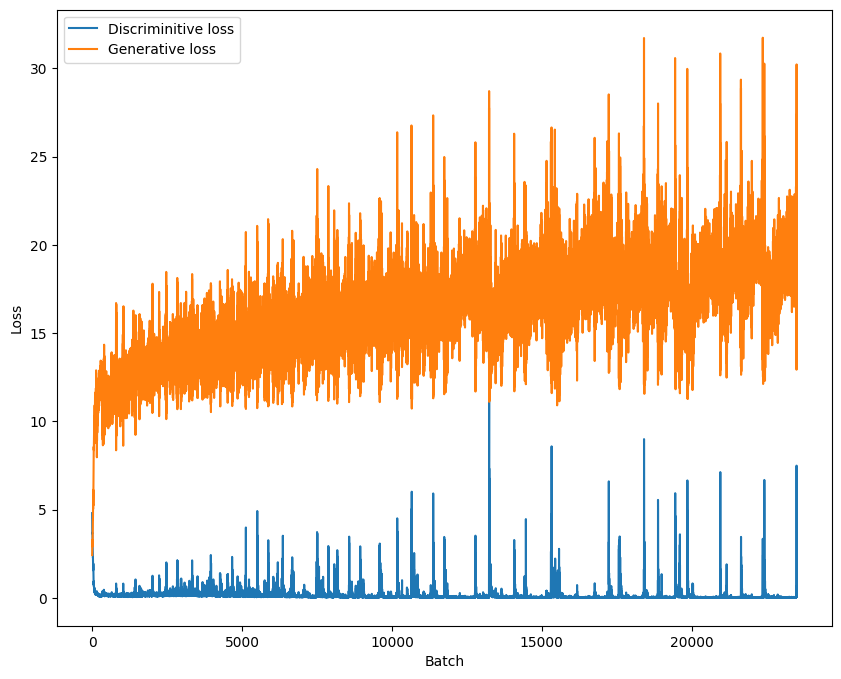

In [16]:
plot_losses(d_losses, g_losses)

In [27]:
G.eval()
generated_images = []
with torch.no_grad():
    for _ in range(2*10):
        random_input = torch.randn(1, 100, 1, 1).to(device)
        output_image = G(random_input)
        generated_images.append(output_image)

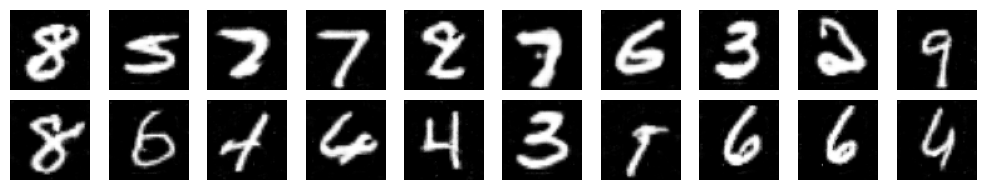

In [28]:
plt.figure(figsize=(10, 2))
for i in range(2*10):
    plt.subplot(2, 10, i + 1)
    img = generated_images[i][0].squeeze().cpu().detach().numpy() 
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [29]:
test_accuracy(D, testloader, device)

100%|██████████| 79/79 [00:02<00:00, 32.48it/s]


85.74